# Analisi dati per l'esperienza di Michelson

in realtà l'analisi dati si potrebbe fare anche in excel ma è brutto come la francia quindi no.

### Import librerie

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple

from colorama import Fore, Style, Back
import scienceplots

plt.style.use(["science", "ieee"])

In [34]:
# print(Fore.RED + "some red text")
# print(Back.BLACK + "and with a green background")
# print(Style.DIM + "and in dim text", Style.BRIGHT + "and in dim text")
# print(Style.RESET_ALL + "back to normal now")

### Import dati

Per ogni sezione dell'esperimento viene caricato un foglio del file excel `Dati_raccolti.xlsx`, in cui sono contenuti solo i valori utili all'analisi statistica dei dati.
A questo punti i dati sono contenuti in un dataframe di Pandas, ovvero una sorta di matrice.

Puliamo i dati, eliminando le righe contenenti solo zeri (`<df>[(<df>.T != 0).any()]`), poi trasponiamo la matrice (`.T`) e la convertiamo un un array di Numpy bidimensionale (`.to_numpy()`).

Infine mostriamo i dati per controllare non si siano verificati errori durante il processo.

In [35]:
f_name = "Dati_raccolti.xlsx"
lambda_data = pd.read_excel(f_name, sheet_name="Export_lambda", header=None)
lambda_data = lambda_data[(lambda_data.T != 0).any()].T.to_numpy()

n_a_data = pd.read_excel(f_name, sheet_name="Export_n", header=None)
n_a_data = n_a_data[(n_a_data.T != 0).any()].T.to_numpy()

white_data = pd.read_excel(f_name, sheet_name="Export_white", header=None)
white_data = white_data[(white_data.T != 0).any()].T.to_numpy()

sodio_data = pd.read_excel(f_name, sheet_name="Export_Na", header=None)
sodio_data = sodio_data[(sodio_data.T != 0).any()].T.to_numpy()

print(lambda_data, n_a_data, white_data, sodio_data, sep="\n")
del f_name  # remove unused variable

[[  7.1    7.39   7.78]
 [  7.33   7.71   8.02]
 [150.   200.   153.  ]]
[[41 42 42]
 [50  0  0]]
[[10.53 10.53]
 [10.63 10.62]]
[[2.    3.    4.    1.   ]
 [0.578 0.842 1.362 0.322]
 [1.156 1.684 2.724 0.644]]


### Misura di $\lambda$

In [36]:
dx = 2 * (lambda_data[1] - lambda_data[0])
N1 = lambda_data[2]
dx_err = np.sqrt(2) * 1e-6  # errore sui dx

del lambda_data


def calc_lambdas(n: float = 1.0) -> np.ndarray[float]:
    return 2 * n * np.divide(dx, N1)


def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values - average) ** 2, weights=weights)
    return (average, np.sqrt(variance))


lambdas = calc_lambdas()
mean_lambda, std_lambda = weighted_avg_and_std(lambdas, 2 * np.divide(dx, N1))

print(lambdas, mean_lambda, std_lambda)

[0.00613333 0.0064     0.00627451] 0.0062711736904937105 0.00010884446808867408


### Misura di $n_a$

In [37]:
N2 = n_a_data[0, :]
D = n_a_data[1, 0]
D_err = 0.1

del n_a_data


def calc_refraction_index(lambdas: np.ndarray[float]) -> np.ndarray[float]:
    return 1 + np.multiply(N2, lambdas) / (2 * D)


n_as = calc_refraction_index(lambdas)
n_as_err = np.multiply(
    np.sqrt(
        np.square(2 / N2) + np.square(std_lambda / mean_lambda) + np.square(D_err / D)
    ),
    n_as,
)
print(n_as, n_as_err)
mean_n_a, std_n_a = weighted_avg_and_std(n_as, n_as_err)
print(mean_n_a, std_n_a)

del lambdas, n_as, n_as_err

[1.00251467 1.002688   1.00263529] [0.05194514 0.05085927 0.0508566 ]
1.0026119607628132 7.275960336145285e-05


### Sistema lineare in $\lambda$ e $n_a$

calcolo con le medie

In [38]:
def sis_lin_medie(mN1=np.mean(N1), mN2=np.mean(N2), mdx=np.mean(dx)) -> Tuple[float]:
    # return (lambda, n_a)
    return 2 * mdx * D / (mN1 * D - mdx * mN2), mN1 * D / (mN1 * D - mdx * mN2)


def sis_lin_err(mN1=np.mean(N1), mN2=np.mean(N2), mdx=np.mean(dx)):
    return (None, None)


mean_lambda_sis, mean_n_a_sis = sis_lin_medie()
std_lambda_sis, std_n_a_sis = sis_lin_err()

calcolo con l'orgia di N

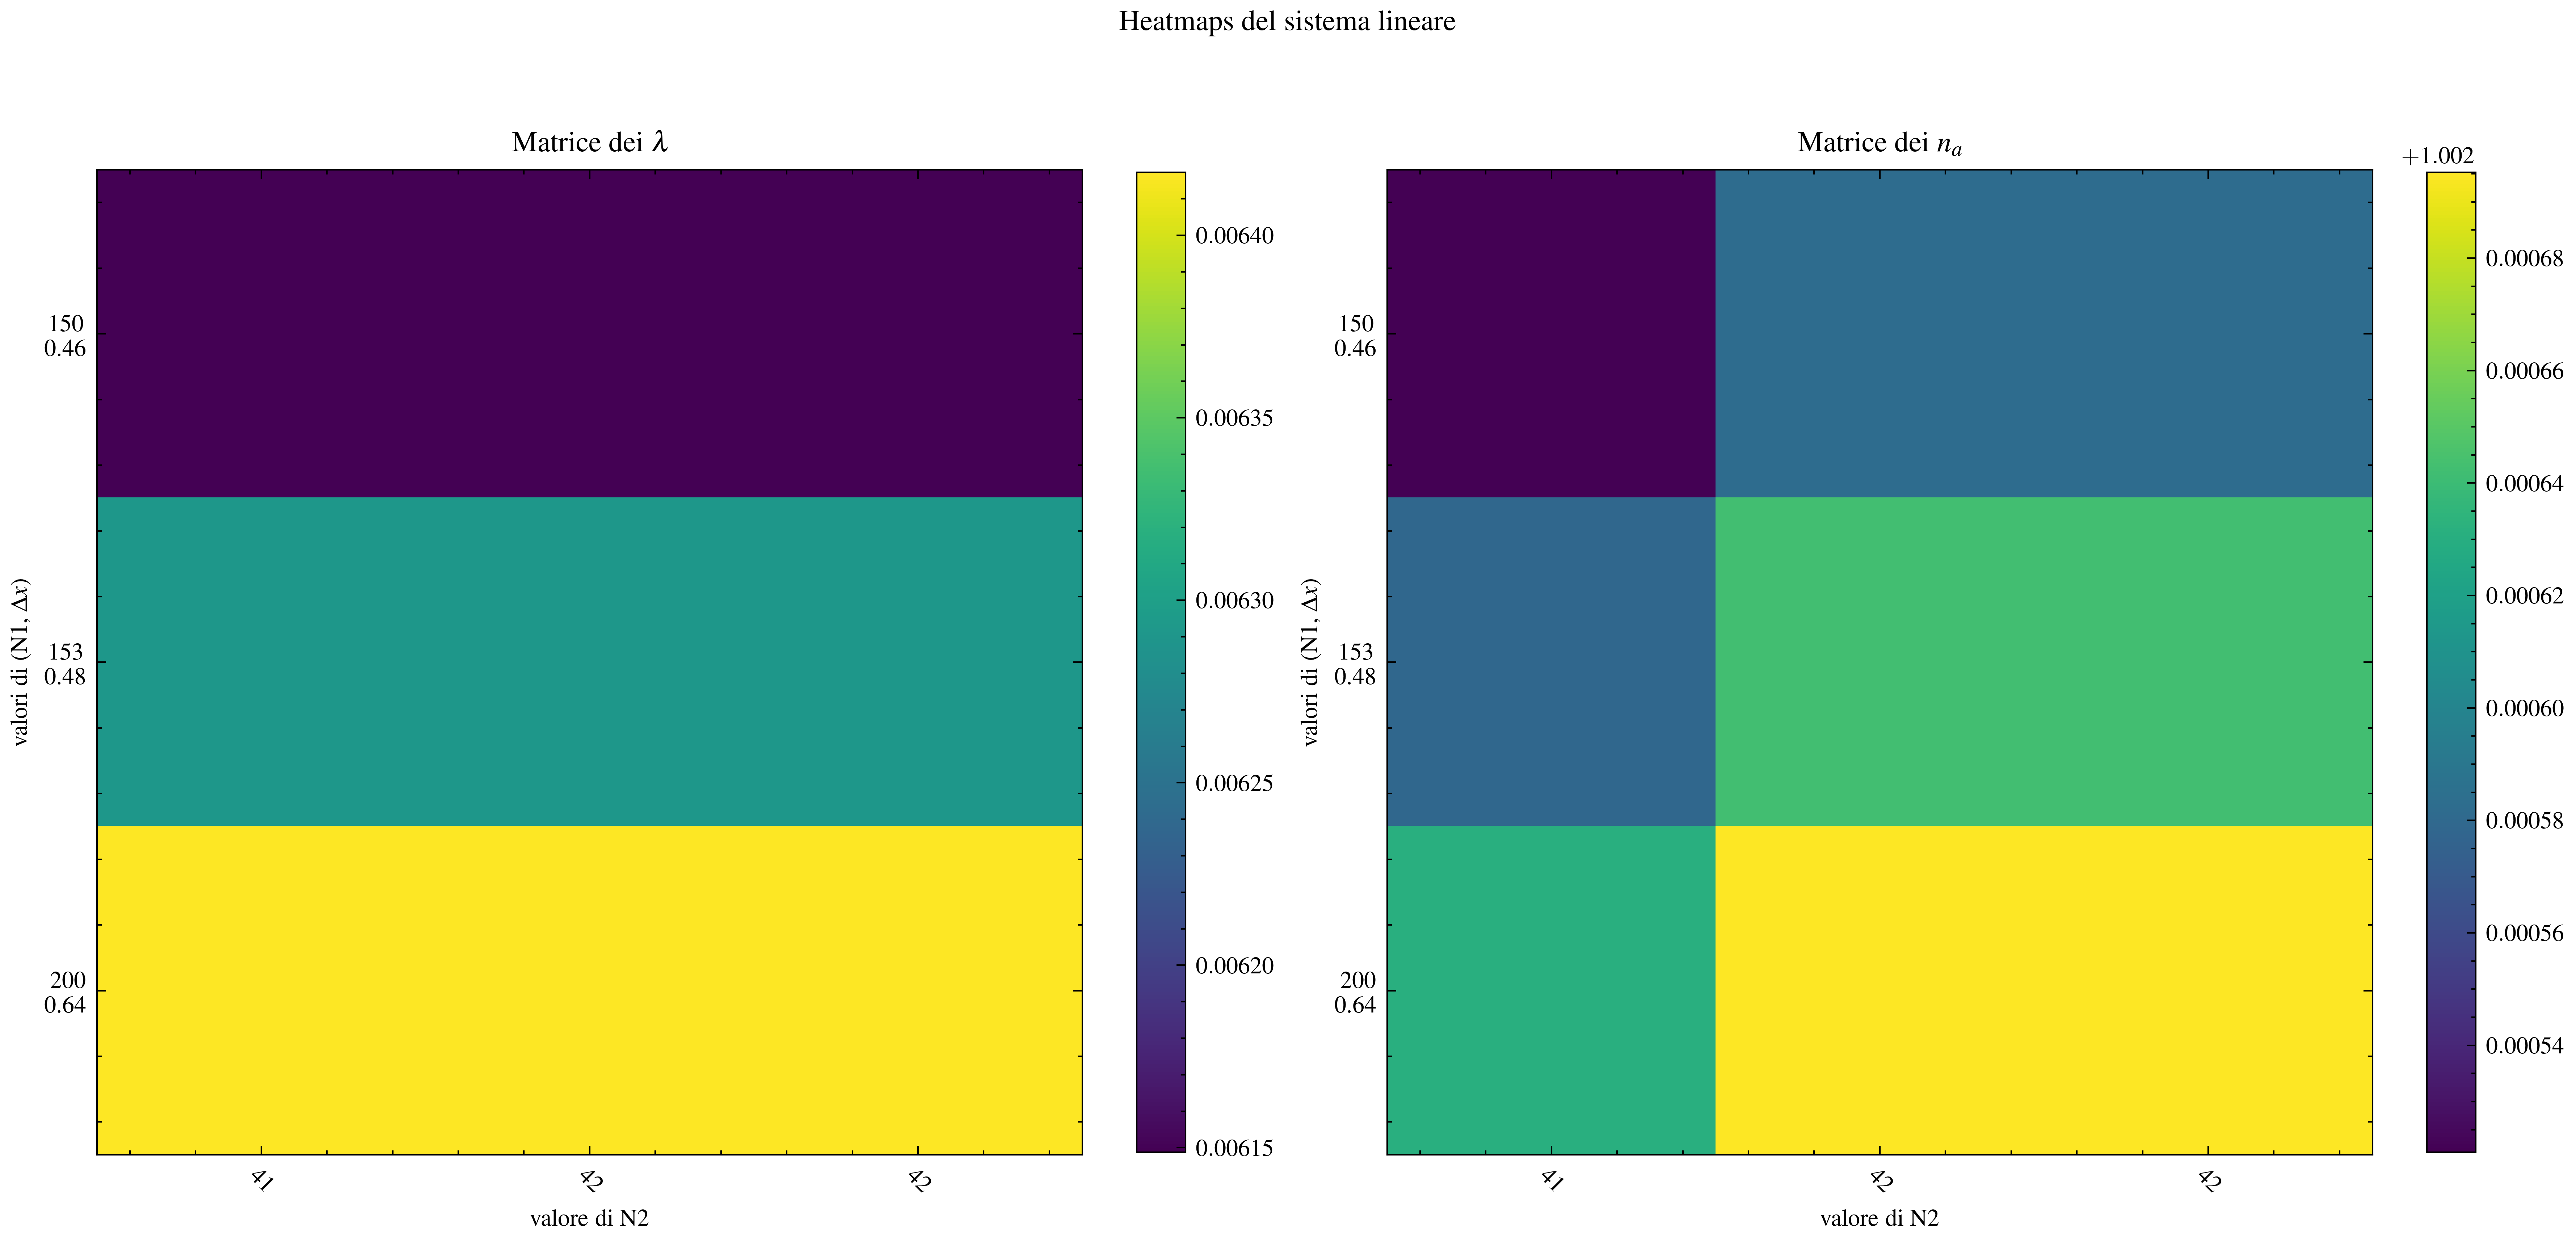

[[0.0061488  0.00614917 0.00614917]
 [0.00629069 0.00629109 0.00629109]
 [0.00641684 0.00641725 0.00641725]]
[[1.00252101 1.00258265 1.00258265]
 [1.00257918 1.00264226 1.00264226]
 [1.0026309  1.00269524 1.00269524]]


In [39]:
def sis_lineare_heatmap() -> Tuple[np.ndarray[float]]:
    M_lambda = np.zeros((len(N1), len(N2)))
    M_n_a = np.zeros((len(N1), len(N2)))

    # Il doppio sort è per avere N1 in ordine e a parità di N1 ordinato per dx
    lambda_zip = sorted(zip(N1, dx), key=lambda x: x[1])
    lambda_zip = sorted(lambda_zip, key=lambda x: x[0])
    sorted_N2 = sorted(N2)
    for i, i_zip in enumerate(lambda_zip):
        i_N1, i_dx = i_zip
        for j, j_N2 in enumerate(sorted_N2):
            M_lambda[i, j], M_n_a[i, j] = sis_lin_medie(mN1=i_N1, mN2=j_N2, mdx=i_dx)

    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
    im = [None, None]
    for i in range(2):
        im[i] = axes[i].imshow(M_lambda if not i else M_n_a)
        axes[i].set_title(f"Matrice dei {r'$\lambda$' if not i else r'$n_a$'}")
        axes[i].set_xlabel("valore di N2")
        axes[i].set_ylabel(r"valori di (N1, $\Delta x$)")
        axes[i].set_xticks(
            np.arange(len(N2)), [f"{n:.3g}" for n in sorted_N2], rotation=-45
        )
        axes[i].set_yticks(
            np.arange(len(N1)), [f"{_n:.3g}\n{_dx:.3g}" for _n, _dx in lambda_zip]
        )
        plt.colorbar(im[i], fraction=0.045, ax=axes[i])

    plt.suptitle("Heatmaps del sistema lineare")
    plt.tight_layout()
    plt.show()

    return M_lambda, M_n_a


M_lambda, M_n_a = sis_lineare_heatmap()
print(M_lambda, M_n_a, sep="\n")
mean_lambda_M, std_lambda_M = M_lambda.flatten().mean(), M_lambda.flatten().std(ddof=1)
mean_n_a_M, std_n_a_M = M_n_a.flatten().mean(), M_n_a.flatten().std(ddof=1)

confronto tra i lambda e n_a iniziali e quelli calcolati dal sistema

In [40]:
print(
    Fore.GREEN
    + Style.BRIGHT
    + r"Confronto tra lambda e n_aria trovati con i vari modi"
    + Style.RESET_ALL
)
print(Style.BRIGHT + r"Media dei valori trovati separatamente" + Style.RESET_ALL)
print(
    rf"lambda = {mean_lambda:.4g} ±{std_lambda:.3g}"
    + "\n"
    + rf"n_aria = {mean_n_a:.6g} ±{std_n_a:.3g}"
)
print(Style.BRIGHT + r"Valori trovati dal sistema delle medie" + Style.RESET_ALL)
print(
    rf"lambda = {mean_lambda_sis:.4g} ±{std_lambda_sis}"  # ! add :.3g
    + "\n"
    + rf"n_aria = {mean_n_a_sis:.6g} ±{std_n_a_sis}"  # ! add :.3g
)
print(
    Style.BRIGHT
    + r"Valori trovati dalla media del sistema di combinazioni"
    + Style.RESET_ALL
)
print(
    rf"lambda = {mean_lambda_M:.4g} ±{std_lambda_M:.3g}"  # ? quanti gradi di libertà ha sta roba?
    + "\n"
    + rf"n_aria = {mean_n_a_M:.6g} ±{std_n_a_M:.3g}"  # ? quanti gradi di libertà ha sta roba?
)

Confronto tra lambda e n_aria trovati con i vari modi
Media dei valori trovati separatamente
lambda = 0.006271 ±0.000109
n_aria = 1.00261 ±7.28e-05
Valori trovati dal sistema delle medie
lambda = 0.006299 ±None
n_aria = 1.00262 ±None
Valori trovati dalla media del sistema di combinazioni
lambda = 0.006286 ±0.000116
n_aria = 1.00262 ±5.77e-05


### Misura dei treni d'onda

In [41]:
dx = 2 * (white_data[1, :] - white_data[0, :])

del white_data

Lp = dx
mean_Lp = Lp.mean()
std_Lp = max(2 * dx_err, Lp.std(ddof=1))
mean_dlambda = mean_lambda_M**2 / mean_Lp  # quale lambda ?
std_dlambda = mean_dlambda * np.sqrt(
    np.square(np.divide(std_lambda_M, mean_lambda_M)) + np.square(std_Lp / mean_dlambda)
)

print(mean_dlambda, std_dlambda)

0.00020794786412979264 0.01414213614569343


### Misura della separazione del doppietto del sodio

In [42]:
dx = 2 * (sodio_data[2, :] - sodio_data[1, :])
m = sodio_data[0, :]

del sodio_data

D_lambdas = 5893**2 * np.divide(m, dx)  # Ångström ^2 / mm?
mean_D_lambda = D_lambdas.mean()
std_D_lambda = D_lambdas.std(ddof=1)

print(mean_D_lambda, std_D_lambda)

56716872.333704896 5111335.098130406
